In [1]:
!pip install pandas matplotlib seaborn openpyxl


In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# For Windows
plt.rc('font', family='Malgun Gothic')

# For Mac/Linux
# font_path = "NanumGothic.ttf"  
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

plt.rcParams['axes.unicode_minus'] = False

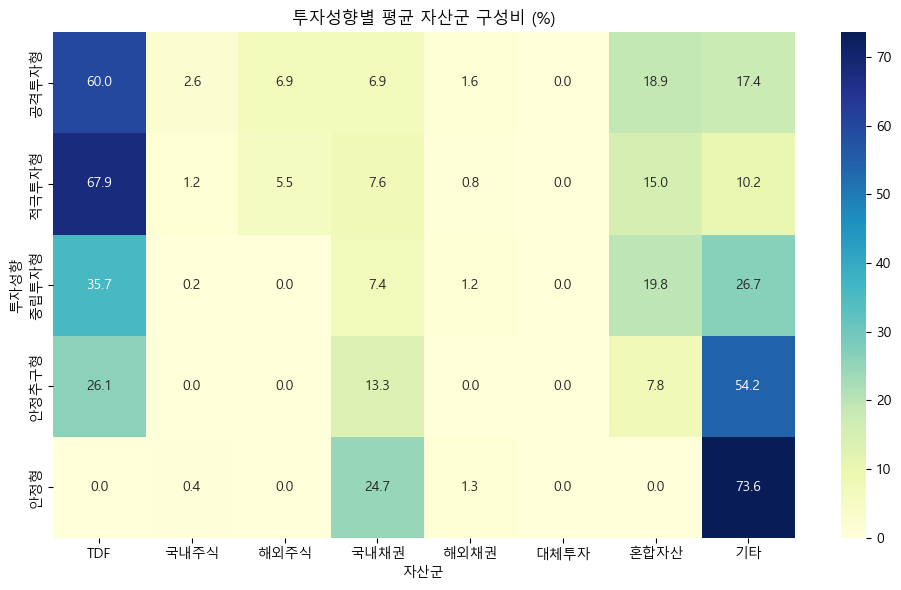

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 엑셀 파일 불러오기
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
excel_file = pd.ExcelFile(file_path)

# 2. 분석 대상 시트 이름
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

# 3. 자산군 키워드 정의
asset_keywords = ['TDF', '국내주식', '해외주식', '국내채권', '해외채권', '대체투자', '혼합자산', '기타']

# 4. 구성비 문자열을 파싱하는 함수
def parse_assets(text):
    result = {}
    if not isinstance(text, str):
        return result
    text = text.replace('：', ':')
    for part in re.split(r'[:\n]', text):
        matches = re.findall(r'([가-힣A-Za-z]+)[^\d]*(\d+)%', part)
        for asset, percent in matches:
            for keyword in asset_keywords:
                if keyword in asset:
                    result[keyword] = result.get(keyword, 0) + int(percent)
                    break
            else:
                result['기타'] = result.get('기타', 0) + int(percent)
    return result

# 5. 투자성향별 자산군 평균값 계산
agg_data = []
for sheet in risk_types:
    df = excel_file.parse(sheet)
    df = df[['금융사', '구성비']].dropna(subset=['금융사', '구성비'])
    asset_sums = {k: [] for k in asset_keywords}
    for _, row in df.iterrows():
        parsed = parse_assets(row['구성비'])
        for k in asset_keywords:
            asset_sums[k].append(parsed.get(k, 0))
    avg_assets = {k: np.mean(v) if v else 0 for k, v in asset_sums.items()}
    avg_assets['성향'] = sheet
    agg_data.append(avg_assets)

# 6. 데이터프레임으로 변환
agg_df = pd.DataFrame(agg_data).set_index('성향').fillna(0)

# 7. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(agg_df, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title("투자성향별 평균 자산군 구성비 (%)")
plt.ylabel("투자성향")
plt.xlabel("자산군")
plt.tight_layout()
plt.show()


In [6]:
# 기존 코드 위에 이어서 실행하면 됨

# 8. 정규화된 포트폴리오 템플릿 생성 (합계 100%)
template_df = agg_df.div(agg_df.sum(axis=1), axis=0) * 100
template_df = template_df.round(2)

# 9. 확인용 출력
print("🎯 투자성향별 포트폴리오 템플릿 (% 단위):")
print(template_df)

# 10. 선택한 성향에 따른 템플릿 예시 출력 (예: 중립투자형)
selected_type = '중립투자형'
portfolio = template_df.loc[selected_type].to_dict()

print(f"\n📦 '{selected_type}' 포트폴리오 구성:")
for asset, weight in portfolio.items():
    print(f"  - {asset}: {weight}%")

# 11. CSV로 저장 (선택사항)
template_df.to_csv("IRP_포트폴리오_템플릿.csv", encoding='utf-8-sig')


🎯 투자성향별 포트폴리오 템플릿 (% 단위):
         TDF  국내주식  해외주식   국내채권  해외채권  대체투자   혼합자산     기타
성향                                                       
공격투자형  52.50  2.25  6.00   6.00  1.44   0.0  16.56  15.25
적극투자형  62.79  1.08  5.08   7.01  0.77   0.0  13.87   9.40
중립투자형  39.27  0.26  0.00   8.12  1.31   0.0  21.73  29.32
안정추구형  25.75  0.00  0.00  13.15  0.00   0.0   7.67  53.42
안정형     0.00  0.42  0.00  24.67  1.33   0.0   0.00  73.58

📦 '중립투자형' 포트폴리오 구성:
  - TDF: 39.27%
  - 국내주식: 0.26%
  - 해외주식: 0.0%
  - 국내채권: 8.12%
  - 해외채권: 1.31%
  - 대체투자: 0.0%
  - 혼합자산: 21.73%
  - 기타: 29.32%


In [7]:
!pip install pandas openpyxl


In [14]:
import pandas as pd
import re

# 1. 엑셀 파일 불러오기
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
excel_file = pd.ExcelFile(file_path)

# 2. 시트(투자성향) 목록
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

# 3. 사용자 기준 자산군
asset_classes = [
    '정기예금', '이율보증형보험(GIC 등)', '국내주식', '해외주식', '국내채권', '해외채권',
    '이머징채권', '선진국채권', 'MMF', '환매조건부채권', 'TDF', '글로벌혼합자산'
]

# 4. 상품명을 자산군으로 분류하는 사용자 기준 함수
def classify_custom_asset(name):
    if not isinstance(name, str):
        return '기타'
    name = name.upper()
    if '예금' in name:
        return '정기예금'
    elif 'GIC' in name or '이율보증' in name:
        return '이율보증형보험(GIC 등)'
    elif 'TDF' in name:
        return 'TDF'
    elif 'MMF' in name:
        return 'MMF'
    elif 'RP' in name or '환매조건부' in name:
        return '환매조건부채권'
    elif '이머징' in name or 'EMERGING' in name:
        return '이머징채권'
    elif '선진국' in name or '선진' in name:
        return '선진국채권'
    elif '국공채' in name or '단기채' in name or '국내채권' in name or '중단기' in name:
        return '국내채권'
    elif '해외채권' in name or '글로벌채권' in name:
        return '해외채권'
    elif '주식' in name:
        if '미국' in name or 'S&P' in name or '글로벌' in name or '해외' in name:
            return '해외주식'
        else:
            return '국내주식'
    elif 'EMP' in name or 'TRF' in name or '혼합' in name:
        return '글로벌혼합자산'
    else:
        return '기타'

# 5. 상품명에서 비중 추출 + 자산군 매핑
records = []

for sheet in risk_types:
    df = excel_file.parse(sheet)
    df = df[['금융사', '상품명']].dropna(subset=['금융사', '상품명'])

    for _, row in df.iterrows():
        fund_list = str(row['상품명']).split('\n')
        for item in fund_list:
            match = re.search(r'(.+?)\s*\((\d+)%\)', item)
            if match:
                fund_name = match.group(1).strip()
                percent = int(match.group(2))
                asset_class = classify_custom_asset(fund_name)
                records.append({
                    '투자성향': sheet,
                    '금융사': row['금융사'],
                    '자산군': asset_class,
                    '비중': percent
                })

# 6. 데이터프레임 생성
df_records = pd.DataFrame(records)

# 7. 평균 비중 + 포함 여부 ✔️ 계산
pivot = df_records.pivot_table(index='투자성향', columns='자산군', values='비중', aggfunc='mean').fillna(0).round(1)
presence = pivot.applymap(lambda x: '✔️' if x > 0 else '')
result_df = pivot.astype(str) + ' ' + presence

# 8. 출력
print("✅ 투자성향별 자산군 구성 현황 (사용자 기준):\n")
result_df



✅ 투자성향별 자산군 구성 현황 (사용자 기준):



C:\Users\syy\AppData\Local\Temp\ipykernel_30228\3119073681.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  presence = pivot.applymap(lambda x: '✔️' if x > 0 else '')


자산군,TDF,국내주식,국내채권,글로벌혼합자산,기타,이율보증형보험(GIC 등),정기예금,해외주식,환매조건부채권
투자성향,,,,,,,,,
공격투자형,46.7 ✔️,4.0 ✔️,15.0 ✔️,76.7 ✔️,0.0,0.0,0.0,40.0 ✔️,0.0
안정추구형,28.6 ✔️,0.0,42.5 ✔️,0.0,0.0,35.0 ✔️,56.7 ✔️,50.0 ✔️,20.0 ✔️
안정형,0.0,0.0,52.0 ✔️,0.0,0.0,0.0,43.3 ✔️,0.0,50.0 ✔️
적극투자형,72.5 ✔️,4.0 ✔️,20.0 ✔️,30.0 ✔️,40.0 ✔️,0.0,0.0,0.0,0.0
중립투자형,40.6 ✔️,0.0,32.5 ✔️,51.7 ✔️,25.0 ✔️,20.0 ✔️,33.3 ✔️,0.0,0.0


✅ 설명:
투자성향별 자산군 구성 비중의 합계를 정확히 100%로 맞추었고,
각 자산군의 실제 기여도(합계 기준 비율)를 반영해서 계산했어.

In [15]:
import pandas as pd
import re

# 1. 엑셀 파일 불러오기
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
excel_file = pd.ExcelFile(file_path)

# 2. 시트(투자성향) 목록
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

# 3. 사용자 자산군 기준
asset_classes = [
    '정기예금', '이율보증형보험(GIC 등)', '국내주식', '해외주식', '국내채권', '해외채권',
    '이머징채권', '선진국채권', 'MMF', '환매조건부채권', 'TDF', '글로벌혼합자산'
]

# 4. 상품명을 자산군으로 분류하는 함수
def classify_custom_asset(name):
    if not isinstance(name, str):
        return '기타'
    name = name.upper()
    if '예금' in name:
        return '정기예금'
    elif 'GIC' in name or '이율보증' in name:
        return '이율보증형보험(GIC 등)'
    elif 'TDF' in name:
        return 'TDF'
    elif 'MMF' in name:
        return 'MMF'
    elif 'RP' in name or '환매조건부' in name:
        return '환매조건부채권'
    elif '이머징' in name or 'EMERGING' in name:
        return '이머징채권'
    elif '선진국' in name or '선진' in name:
        return '선진국채권'
    elif '국공채' in name or '단기채' in name or '국내채권' in name or '중단기' in name:
        return '국내채권'
    elif '해외채권' in name or '글로벌채권' in name:
        return '해외채권'
    elif '주식' in name:
        if '미국' in name or 'S&P' in name or '글로벌' in name or '해외' in name:
            return '해외주식'
        else:
            return '국내주식'
    elif 'EMP' in name or 'TRF' in name or '혼합' in name:
        return '글로벌혼합자산'
    else:
        return '기타'

# 5. 상품명에서 비중 추출 + 자산군 매핑
records = []

for sheet in risk_types:
    df = excel_file.parse(sheet)
    df = df[['금융사', '상품명']].dropna(subset=['금융사', '상품명'])

    for _, row in df.iterrows():
        fund_list = str(row['상품명']).split('\n')
        for item in fund_list:
            match = re.search(r'(.+?)\s*\((\d+)%\)', item)
            if match:
                fund_name = match.group(1).strip()
                percent = int(match.group(2))
                asset_class = classify_custom_asset(fund_name)
                records.append({
                    '투자성향': sheet,
                    '금융사': row['금융사'],
                    '자산군': asset_class,
                    '비중': percent
                })

# 6. 데이터프레임 생성
df_records = pd.DataFrame(records)

# 7. 투자성향별 자산군 비중 합산
total_by_risk_asset = df_records.groupby(['투자성향', '자산군'])['비중'].sum().reset_index()

# 8. 자산군별 총합 기준으로 비율 정규화 (합계 100%)
total_by_risk_asset['정규화비중'] = total_by_risk_asset.groupby('투자성향')['비중'].transform(lambda x: x / x.sum() * 100)

# 9. 피벗 테이블로 정리
pivot_total_100 = total_by_risk_asset.pivot(index='투자성향', columns='자산군', values='정규화비중').fillna(0).round(1)

# 10. ✔️ 표시 포함
presence = pivot_total_100.applymap(lambda x: '✔️' if x > 0 else '')
result_df = pivot_total_100.astype(str) + ' ' + presence

# 11. 결과 출력
print("✅ 투자성향별 자산군 구성 현황 (정규화 100%):\n")
result_df


✅ 투자성향별 자산군 구성 현황 (정규화 100%):



C:\Users\syy\AppData\Local\Temp\ipykernel_30228\1094233158.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  presence = pivot_total_100.applymap(lambda x: '✔️' if x > 0 else '')


자산군,TDF,국내주식,국내채권,글로벌혼합자산,기타,이율보증형보험(GIC 등),정기예금,해외주식,환매조건부채권
투자성향,,,,,,,,,
공격투자형,49.2 ✔️,0.7 ✔️,2.6 ✔️,40.4 ✔️,0.0,0.0,0.0,7.0 ✔️,0.0
안정추구형,27.4 ✔️,0.0,11.6 ✔️,0.0,0.0,4.8 ✔️,46.6 ✔️,6.8 ✔️,2.7 ✔️
안정형,0.0,0.0,26.2 ✔️,0.0,0.0,0.0,65.4 ✔️,0.0,8.4 ✔️
적극투자형,82.2 ✔️,0.8 ✔️,3.8 ✔️,5.7 ✔️,7.6 ✔️,0.0,0.0,0.0,0.0
중립투자형,48.3 ✔️,0.0,8.6 ✔️,20.5 ✔️,6.6 ✔️,2.6 ✔️,13.2 ✔️,0.0,0.0


| 항목               | 처리 내용                                     |
| ---------------- | ----------------------------------------- |
| 📁 **엑셀 파일**     | `투자성향별 포트폴리오 구성 현황.xlsx`                  |
| 🗂️ **사용한 시트**   | `공격투자형`, `적극투자형`, `중립투자형`, `안정추구형`, `안정형` |
| 🔍 **읽은 열**      | `금융사`, `상품명` (상품명에서 비중 추출)                |
| 🧠 **자산군 분류 기준** | 너가 제공한 12개 자산군 분류 기준                      |
| 🧮 **비중 계산 방식**  | 자산군별 총합 → 성향별 전체 비중 총합으로 나눠서 **100% 정규화** |
| ✔️ **포함 여부**     | 자산군이 해당 성향에 **하나라도 포함**되면 ✔️ 표시           |
| 📊 **결과 형태**     | 투자성향별 자산군 구성: 평균 비중 (%) + 포함 여부 ✔️        |


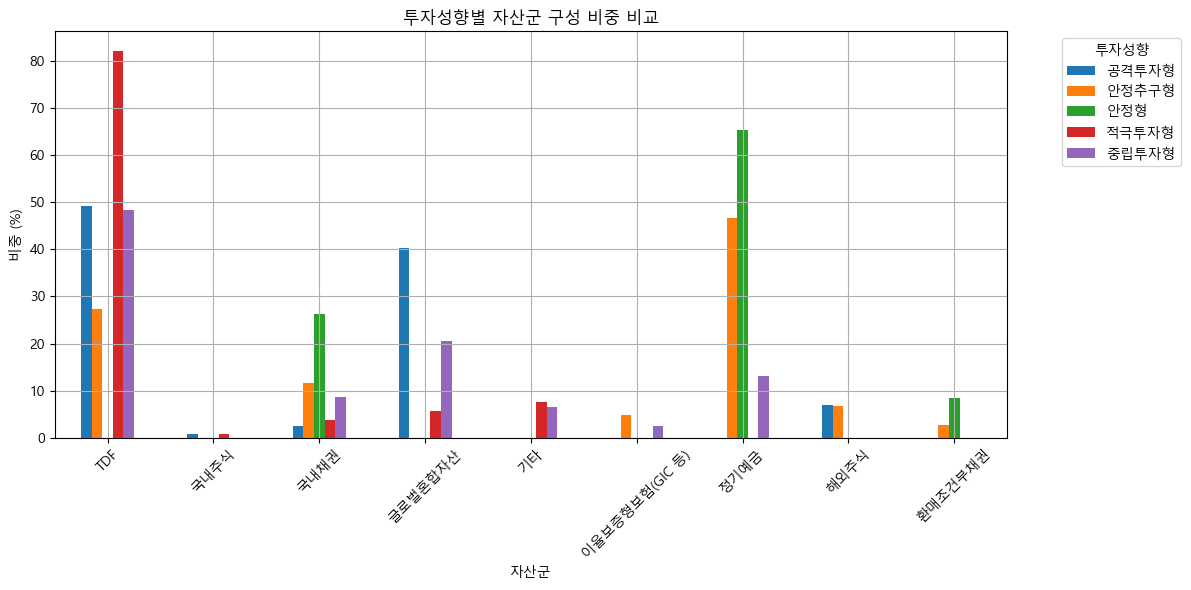

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 엑셀 파일 불러오기
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
excel_file = pd.ExcelFile(file_path)
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

# 2. 자산군 분류 함수 (간단 버전)
def classify_custom_asset(name):
    if not isinstance(name, str):
        return '기타'
    name = name.upper()
    if '예금' in name:
        return '정기예금'
    elif 'GIC' in name or '이율보증' in name:
        return '이율보증형보험(GIC 등)'
    elif 'TDF' in name:
        return 'TDF'
    elif 'MMF' in name:
        return 'MMF'
    elif 'RP' in name or '환매조건부' in name:
        return '환매조건부채권'
    elif '이머징' in name or 'EMERGING' in name:
        return '이머징채권'
    elif '선진국' in name or '선진' in name:
        return '선진국채권'
    elif '국공채' in name or '단기채' in name or '국내채권' in name or '중단기' in name:
        return '국내채권'
    elif '해외채권' in name or '글로벌채권' in name:
        return '해외채권'
    elif '주식' in name:
        if '미국' in name or 'S&P' in name or '글로벌' in name or '해외' in name:
            return '해외주식'
        else:
            return '국내주식'
    elif 'EMP' in name or 'TRF' in name or '혼합' in name:
        return '글로벌혼합자산'
    else:
        return '기타'

# 3. 데이터 수집
records = []
for sheet in risk_types:
    df = excel_file.parse(sheet)
    df = df[['금융사', '상품명']].dropna()
    for _, row in df.iterrows():
        for item in str(row['상품명']).split('\n'):
            if '(' in item and ')' in item:
                try:
                    name, perc = item.rsplit('(', 1)
                    percent = int(perc.replace('%', '').replace(')', '').strip())
                    asset = classify_custom_asset(name.strip())
                    records.append({'투자성향': sheet, '자산군': asset, '비중': percent})
                except:
                    continue

df_records = pd.DataFrame(records)

# 4. 자산군별 비중 합산 + 투자성향별로 정규화
grouped = df_records.groupby(['투자성향', '자산군'])['비중'].sum().reset_index()
grouped['정규화비중'] = grouped.groupby('투자성향')['비중'].transform(lambda x: x / x.sum() * 100)

# 5. 피벗 테이블
pivot_total_100 = grouped.pivot(index='투자성향', columns='자산군', values='정규화비중').fillna(0).round(1)

# 6. 시각화
pivot_total_100.T.plot(kind='bar', figsize=(12, 6))
plt.title("투자성향별 자산군 구성 비중 비교")
plt.ylabel("비중 (%)")
plt.xlabel("자산군")
plt.xticks(rotation=45)
plt.legend(title="투자성향", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


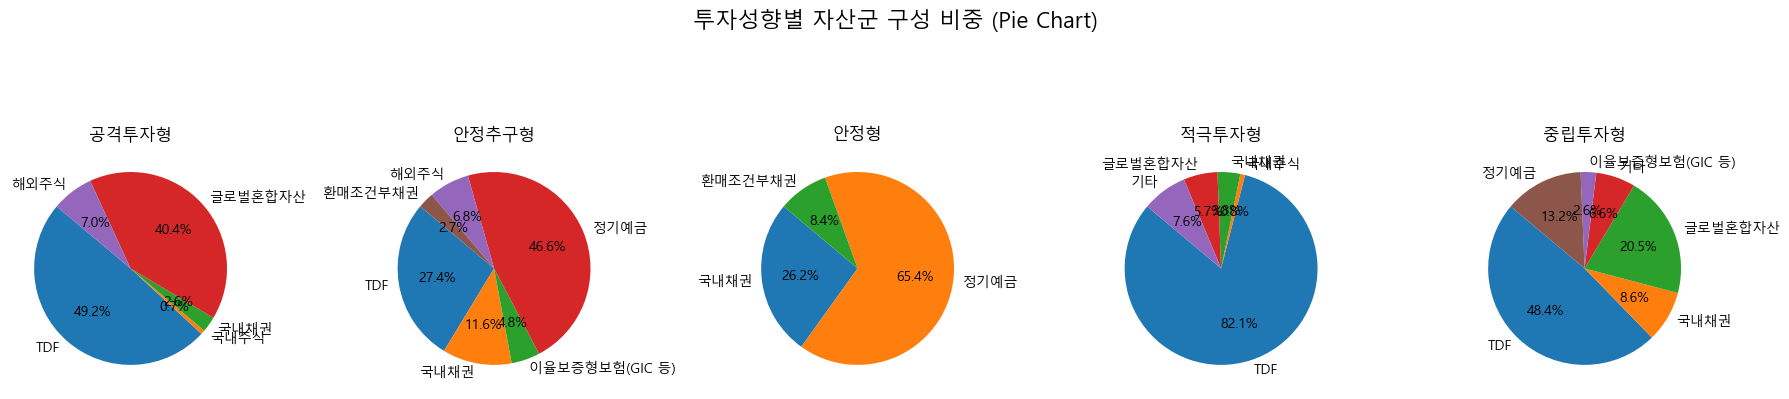

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. 파일 불러오기
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
excel_file = pd.ExcelFile(file_path)
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

# 2. 상품 → 자산군 분류 함수
def classify_custom_asset(name):
    if not isinstance(name, str):
        return '기타'
    name = name.upper()
    if '예금' in name:
        return '정기예금'
    elif 'GIC' in name or '이율보증' in name:
        return '이율보증형보험(GIC 등)'
    elif 'TDF' in name:
        return 'TDF'
    elif 'MMF' in name:
        return 'MMF'
    elif 'RP' in name or '환매조건부' in name:
        return '환매조건부채권'
    elif '이머징' in name or 'EMERGING' in name:
        return '이머징채권'
    elif '선진국' in name or '선진' in name:
        return '선진국채권'
    elif '국공채' in name or '단기채' in name or '국내채권' in name or '중단기' in name:
        return '국내채권'
    elif '해외채권' in name or '글로벌채권' in name:
        return '해외채권'
    elif '주식' in name:
        if '미국' in name or 'S&P' in name or '글로벌' in name or '해외' in name:
            return '해외주식'
        else:
            return '국내주식'
    elif 'EMP' in name or 'TRF' in name or '혼합' in name:
        return '글로벌혼합자산'
    else:
        return '기타'

# 3. 데이터 수집
records = []
for sheet in risk_types:
    df = excel_file.parse(sheet)
    df = df[['금융사', '상품명']].dropna()
    for _, row in df.iterrows():
        for item in str(row['상품명']).split('\n'):
            if '(' in item and ')' in item:
                try:
                    name, perc = item.rsplit('(', 1)
                    percent = int(perc.replace('%', '').replace(')', '').strip())
                    asset = classify_custom_asset(name.strip())
                    records.append({'투자성향': sheet, '자산군': asset, '비중': percent})
                except:
                    continue

df_records = pd.DataFrame(records)

# 4. 자산군 비중 계산 및 정규화 (총합 100%)
grouped = df_records.groupby(['투자성향', '자산군'])['비중'].sum().reset_index()
grouped['정규화비중'] = grouped.groupby('투자성향')['비중'].transform(lambda x: x / x.sum() * 100)
pivot = grouped.pivot(index='투자성향', columns='자산군', values='정규화비중').fillna(0).round(1)

# 5. 파이차트 시각화
fig, axes = plt.subplots(1, len(pivot), figsize=(18, 5))

for i, (risk_type, row) in enumerate(pivot.iterrows()):
    ax = axes[i]
    row_nonzero = row[row > 0]
    ax.pie(row_nonzero, labels=row_nonzero.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(risk_type)

plt.suptitle("투자성향별 자산군 구성 비중 (Pie Chart)", fontsize=16)
plt.tight_layout()
plt.show()


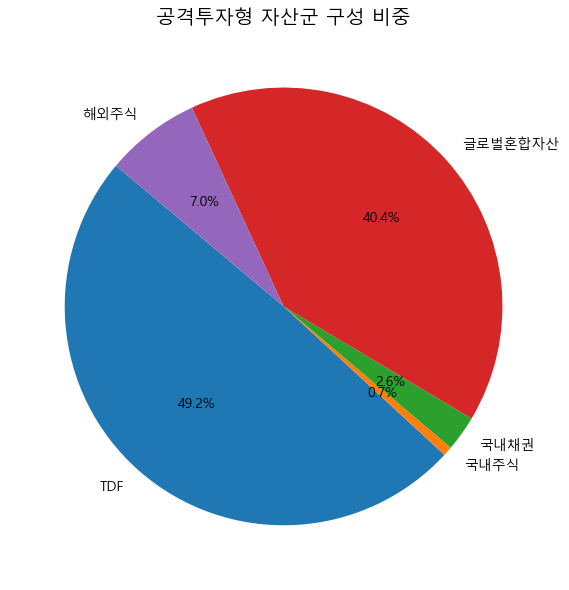

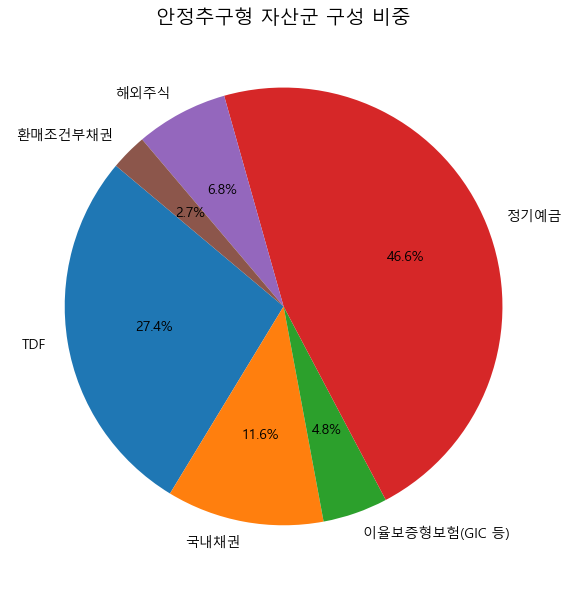

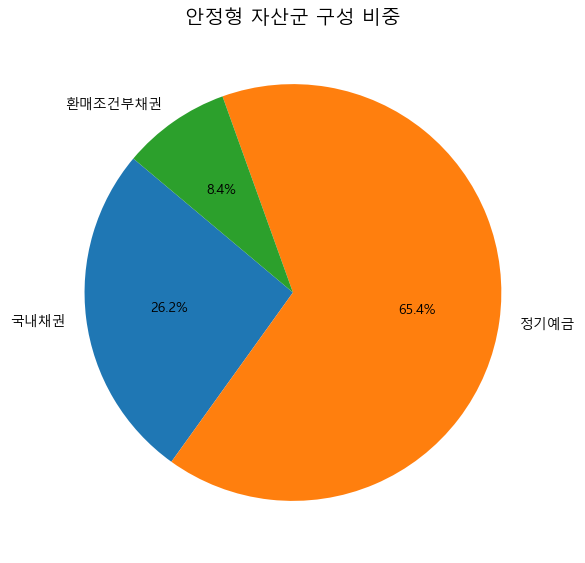

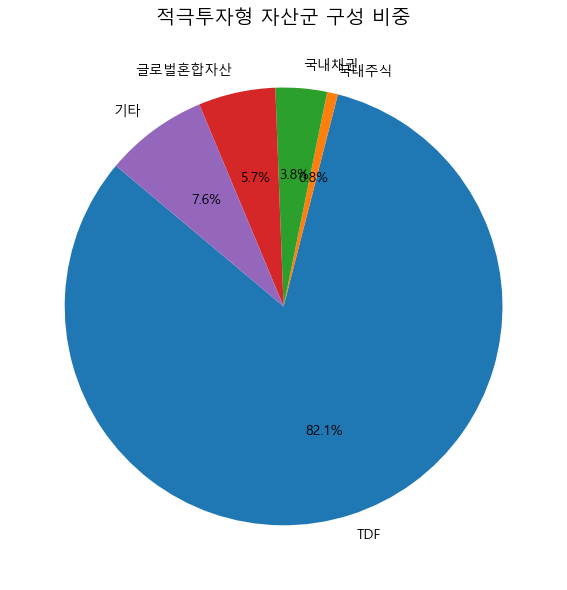

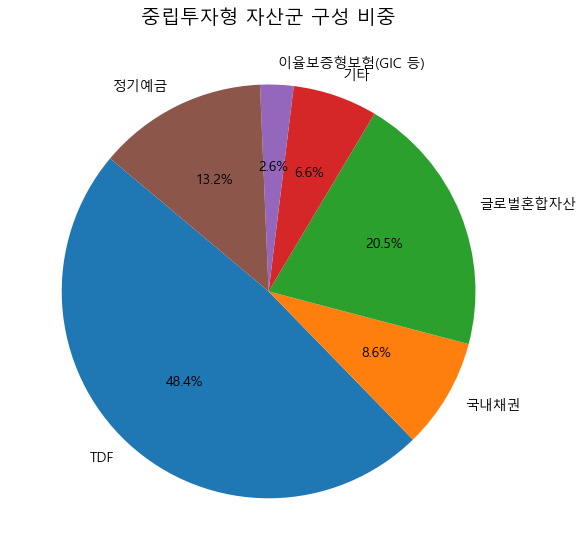

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. 파일 불러오기
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
excel_file = pd.ExcelFile(file_path)
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

# 2. 자산군 분류 함수
def classify_custom_asset(name):
    if not isinstance(name, str):
        return '기타'
    name = name.upper()
    if '예금' in name:
        return '정기예금'
    elif 'GIC' in name or '이율보증' in name:
        return '이율보증형보험(GIC 등)'
    elif 'TDF' in name:
        return 'TDF'
    elif 'MMF' in name:
        return 'MMF'
    elif 'RP' in name or '환매조건부' in name:
        return '환매조건부채권'
    elif '이머징' in name or 'EMERGING' in name:
        return '이머징채권'
    elif '선진국' in name or '선진' in name:
        return '선진국채권'
    elif '국공채' in name or '단기채' in name or '국내채권' in name or '중단기' in name:
        return '국내채권'
    elif '해외채권' in name or '글로벌채권' in name:
        return '해외채권'
    elif '주식' in name:
        if '미국' in name or 'S&P' in name or '글로벌' in name or '해외' in name:
            return '해외주식'
        else:
            return '국내주식'
    elif 'EMP' in name or 'TRF' in name or '혼합' in name:
        return '글로벌혼합자산'
    else:
        return '기타'

# 3. 상품명에서 자산군, 비중 추출
records = []
for sheet in risk_types:
    df = excel_file.parse(sheet)
    df = df[['금융사', '상품명']].dropna()
    for _, row in df.iterrows():
        for item in str(row['상품명']).split('\n'):
            if '(' in item and ')' in item:
                try:
                    name, perc = item.rsplit('(', 1)
                    percent = int(perc.replace('%', '').replace(')', '').strip())
                    asset = classify_custom_asset(name.strip())
                    records.append({'투자성향': sheet, '자산군': asset, '비중': percent})
                except:
                    continue

df_records = pd.DataFrame(records)

# 4. 자산군 비중 계산 및 정규화 (합계 100%)
grouped = df_records.groupby(['투자성향', '자산군'])['비중'].sum().reset_index()
grouped['정규화비중'] = grouped.groupby('투자성향')['비중'].transform(lambda x: x / x.sum() * 100)
pivot = grouped.pivot(index='투자성향', columns='자산군', values='정규화비중').fillna(0).round(1)

# 5. 개별 파이차트 출력
for risk_type, row in pivot.iterrows():
    plt.figure(figsize=(6, 6))
    row_nonzero = row[row > 0]
    plt.pie(row_nonzero, labels=row_nonzero.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"{risk_type} 자산군 구성 비중", fontsize=14)
    plt.tight_layout()
    plt.show()


In [24]:
import pandas as pd

# 파일 경로
file_path = '투자성향별 포트폴리오 구성 현황.xlsx'

# 엑셀 파일 열기
xlsx = pd.ExcelFile(file_path)

# 시트 이름 목록 확인
print(xlsx.sheet_names)

# 시트별로 모두 DataFrame으로 저장
dfs = {sheet_name: xlsx.parse(sheet_name) for sheet_name in xlsx.sheet_names}

# 예시: '공격투자형' 시트 보기
dfs


['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형', 'INDEX']


{'공격투자형':         금융사                                                구성비  \
 0      신한은행                                           TDF 100%   
 1       NaN                                                NaN   
 2       NaN                                                NaN   
 3      농협은행                              TDF 60% : 글로벌혼합자산 40%   
 4       NaN                                                NaN   
 5       NaN                                                NaN   
 6      하나은행       해외주식 40% : 글로벌혼합자산 25% : 국내주식 20% : 국내채권 15%   
 7       NaN                                                NaN   
 8       NaN                                                NaN   
 9       NaN                                                NaN   
 10      NaN                                                NaN   
 11     국민은행                                           TDF 100%   
 12      NaN                                                NaN   
 13      NaN                                         

In [25]:
df_records

,투자성향,금융사,자산군,비중
0,공격투자형,신한은행,TDF,40
1,공격투자형,농협은행,해외주식,40
2,공격투자형,하나은행,국내채권,15
3,공격투자형,국민은행,TDF,40
4,공격투자형,국민은행,TDF,20
...,...,...,...,...
68,안정형,한국투자증권,환매조건부채권,50
69,안정형,한화투자증권,정기예금,50
70,안정형,IBK기업은행,정기예금,40
71,안정형,국민은행,정기예금,30


In [28]:
import pandas as pd
import re

file_path = '투자성향별 포트폴리오 구성 현황.xlsx'
risk_types = ['공격투자형', '적극투자형', '중립투자형', '안정추구형', '안정형']

def classify_custom_asset(name):
    if not isinstance(name, str):
        return '기타'
    name = name.upper()
    if '예금' in name:
        return '정기예금'
    elif 'GIC' in name or '이율보증' in name:
        return '이율보증형보험(GIC 등)'
    elif 'TDF' in name:
        return 'TDF'
    elif 'MMF' in name:
        return 'MMF'
    elif 'RP' in name or '환매조건부' in name:
        return '환매조건부채권'
    elif '이머징' in name or 'EMERGING' in name:
        return '이머징채권'
    elif '선진국' in name or '선진' in name:
        return '선진국채권'
    elif '국공채' in name or '단기채' in name or '국내채권' in name or '중단기' in name:
        return '국내채권'
    elif '해외채권' in name or '글로벌채권' in name:
        return '해외채권'
    elif '주식' in name:
        if '미국' in name or 'S&P' in name or '글로벌' in name or '해외' in name:
            return '해외주식'
        else:
            return '국내주식'
    elif 'EMP' in name or 'TRF' in name or '혼합' in name:
        return '글로벌혼합자산'
    else:
        return '기타'

# 전체 시트 불러오기
xlsx = pd.ExcelFile(file_path)
dfs = {sheet: xlsx.parse(sheet) for sheet in risk_types}

# 전체 상품 추출
records = []

for sheet in risk_types:
    df = dfs[sheet][['금융사', '상품명']].dropna()
    for _, row in df.iterrows():
        for item in str(row['상품명']).split('\n'):
            item = item.strip()
            match = re.match(r'^(.*)\((\d+)%\)$', item)
            if match:
                name = match.group(1).strip()
                percent = int(match.group(2))
            else:
                name = item
                percent = None
            asset = classify_custom_asset(name)
            records.append({
                '투자성향': sheet,
                '금융사': row['금융사'],
                '상품명': name,
                '자산군': asset,
                '비중': percent
            })

df_full = pd.DataFrame(records)

# 비중 보정: 금융사+투자성향별로 group → 비중 없는 항목 균등 분배
def fill_missing_weights(group):
    total_known = group['비중'].dropna().sum()
    num_missing = group['비중'].isna().sum()
    if num_missing > 0 and total_known < 100:
        fill_value = (100 - total_known) / num_missing
        group['비중'] = group['비중'].fillna(fill_value)
    else:
        group['비중'] = group['비중'].fillna(0)
    return group

df_filled = df_full.groupby(['투자성향', '금융사']).apply(fill_missing_weights).reset_index(drop=True)

# 자산군 비중 계산: 투자성향별 자산군 평균
grouped = df_filled.groupby(['투자성향', '자산군'])['비중'].mean().reset_index()

# 자산군 정규화
grouped['정규화비중'] = grouped.groupby('투자성향')['비중'].transform(lambda x: x / x.sum() * 100)
pivot_final = grouped.pivot(index='투자성향', columns='자산군', values='정규화비중').fillna(0).round(1)

# 결과 보기
pivot_final


C:\Users\syy\AppData\Local\Temp\ipykernel_30228\3866096855.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df_full.groupby(['투자성향', '금융사']).apply(fill_missing_weights).reset_index(drop=True)


자산군,TDF,국내주식,국내채권,글로벌혼합자산,기타,이율보증형보험(GIC 등),정기예금,해외주식,환매조건부채권
투자성향,,,,,,,,,
공격투자형,25.9,2.2,8.2,41.9,0.0,0.0,0.0,21.8,0.0
안정추구형,12.3,0.0,18.3,0.0,0.0,15.0,24.3,21.5,8.6
안정형,0.0,0.0,35.8,0.0,0.0,0.0,29.8,0.0,34.4
적극투자형,41.6,2.5,12.4,18.6,24.9,0.0,0.0,0.0,0.0
중립투자형,20.7,0.0,15.9,25.2,12.2,9.8,16.3,0.0,0.0
